### Quick Exploration of KWS Dataset



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import matplotlib.pyplot as plt

In [2]:
# num_examples per keyword
# also, num_examples with exactly 16k samples (i.e. 1sec exactly)
print('keyword\t\tnum_examples\tnum_16kexamples')
grand_total = 0
grand_total_16k = 0
for folder in glob.glob('../data/train/audio/*'):
    total = 0
    total_16k = 0
    label = folder.split('/')[-1]
    for wav_file in glob.glob('../data/train/audio/{}/*.wav'.format(label)):
        total += 1
        rawdata = tf.io.read_file(wav_file)
        samples = tf.audio.decode_wav(rawdata)
        if samples.audio.shape[0] == 16000:
            total_16k += 1
    print('{}\t\t{}\t\t{}'.format(label, total, total_16k))
    grand_total += total
    grand_total_16k += total_16k
print('TOTAL\t\t{}\t\t{}'.format(grand_total, grand_total_16k))

keyword		num_examples	num_16kexamples
right		2367		2155
eight		2352		2111
cat		1733		1515
tree		1733		1521
bed		1713		1484
happy		1742		1549
go		2372		2101
dog		1746		1547
no		2375		2098
wow		1745		1525
nine		2364		2174
left		2353		2165
stop		2380		2174
three		2356		2143
_background_noise_		6		0
sheila		1734		1578
one		2370		2103
bird		1731		1521
zero		2376		2203
seven		2377		2170
up		2375		2062
marvin		1746		1578
two		2373		2140
house		1750		1560
down		2359		2152
six		2369		2199
yes		2377		2157
on		2367		2105
five		2357		2161
off		2357		2143
four		2372		2158
TOTAL		64727		58252


In [3]:
# load a few examples each of a couple words
num_examples = 5
words = ['sheila', 'one']
word_filenames = []
for w in words:
    word_filenames.append(glob.glob('../data/train/audio/{}/*.wav'.format(w)))

samples_list = []
for word_idx, fn_list in enumerate(word_filenames):
    n = 0
    for fn in fn_list:
        rawdata = tf.io.read_file(fn)
        samples = tf.audio.decode_wav(rawdata).audio
        if samples.shape[0] != 16000:
            continue  # skip captures not equal to 1 second
        samples_list.append(samples)
        n += 1
        if n >= num_examples:
            break
samples = tf.concat(samples_list, axis=-1)
samples = tf.transpose(samples, perm=[1, 0])

In [10]:
# compute log-mel spectrograms
n_mel_bins = 30
stfts = tf.signal.stft(samples, frame_length=512, frame_step=256)
spectrograms = tf.abs(stfts)
N = spectrograms.shape[0]  # number of spectrograms
# spectrograms.shape = (N, 61, 257)
M = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=n_mel_bins,
    num_spectrogram_bins=257,
    sample_rate=16000,
    lower_edge_hertz=40,
    upper_edge_hertz=8000)
# M.shape = (257, n_mel_bins)
# tf.reshape because tf.matmul doesn't support broadcasting
spectrograms = tf.reshape(spectrograms, (-1, 257))
mel_spectrograms = spectrograms @ M
mel_spectrograms = tf.reshape(mel_spectrograms, (N, 61, n_mel_bins))
# log-mel and permute to index rows by frequency and columns by time
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
log_mel_spectrograms = tf.transpose(log_mel_spectrograms, perm=[0, 2, 1])

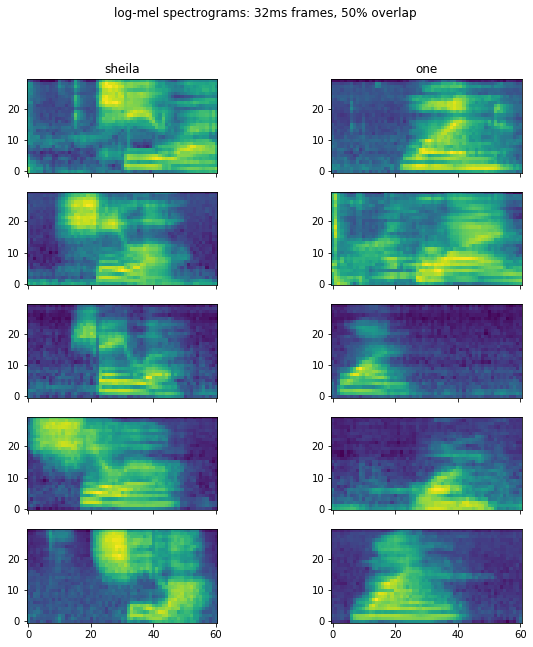

In [9]:
fig, axs = plt.subplots(5, 2, sharex=True)
fig.set_size_inches(10, 10)
for i in range(log_mel_spectrograms.shape[0]):
    axs[i%5, i//5].imshow(log_mel_spectrograms[i, ...],
                          origin='lower')
for i, w in enumerate(words):
    axs[0, i].set_title(w)
fig.suptitle('log-mel spectrograms: 32ms frames, 50% overlap')
plt.show()